In [73]:
import pandas as pd
import numpy as np
import json


file_mode = "../data/ACTU_STOPS_0.csv"
file_trips = "../data/gtfs3Sept/trips.csv"
file_routes = "../data/gtfs3Sept/routes.csv"
file_stop_times = "../data/gtfs3Sept/stop_times.csv"
file_stops = "../data/gtfs3Sept/stops.csv"
file_calendar = "../data/gtfs3Sept/calendar.csv"

In [3]:
# df_stops = pd.read_csv(file_stops)

In [4]:
"""
Creation of the metro trips dataset
"""

# Read the files
df_mode = pd.read_csv(file_mode)
df_trips = pd.read_csv(file_trips)
df_routes = pd.read_csv(file_routes)

# Only keep the Metro examples
df_mode_metro = df_mode[df_mode["mode"]=="M"]
# print(df_mode_metro)


df_metro_id_str = df_mode_metro.numero_lig.astype(str)
df_routes_metro = df_routes[df_routes.route_short_name.isin(df_metro_id_str)]
# print(df_routes_metro)

df_metro_trips = df_trips[df_trips.route_id.isin(df_routes_metro.route_id)]
df_metro_trips = df_metro_trips.drop(["trip_headsign", "block_id", "shape_id"], axis=1)
print(pd.DataFrame(df_metro_trips))

       route_id  service_id             trip_id  direction_id
80299         1   234578052  112585711234578052             1
80300         1   234578052  112585712234578052             1
80301         1   234578052  112585714234578052             0
80302         1   234578052  112585715234578052             0
80303         1   234578052  112585717234578052             1
...         ...         ...                 ...           ...
88833         1   237269601  113423843237269601             1
88834         1   237269601  113423845237269601             0
88835         1   237269601  113423847237269601             1
88836         1   237269601  113423849237269601             0
88837         1   237269601  113423851237269601             1

[8539 rows x 4 columns]


In [5]:
"""
filtering the calendar dataset in week, saturday, sunday
"""
df_calendar = pd.read_csv(file_calendar)
df_calendar["week"] = df_calendar['monday']*df_calendar['tuesday']*df_calendar['wednesday']*df_calendar['thursday']*df_calendar['friday']
df_calendar.drop(['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'start_date', 'end_date'], inplace=True, axis=1)

print(pd.DataFrame(df_calendar))

     service_id  saturday  sunday  week
0     234578052         0       0     1
1     236986502         1       0     0
2     236988602         0       1     0
3     236270000         0       0     1
4     236269500         1       0     0
..          ...       ...     ...   ...
432   237102501         1       0     0
433   237472602         0       1     0
434   237451600         0       1     0
435   238036502         1       0     0
436   238255501         1       0     0

[437 rows x 4 columns]


In [6]:
"""
joining calendar and metro trip
"""
df_metro_trip_calendar = pd.merge(df_metro_trips, df_calendar, on="service_id")

df_metro_trip_calendar.saturday = df_metro_trip_calendar.saturday+df_metro_trip_calendar.sunday
df_metro_trip_calendar.drop("sunday", inplace=True, axis=1)
print(pd.DataFrame(df_metro_trip_calendar))



      route_id  service_id             trip_id  direction_id  saturday  week
0            1   234578052  112585711234578052             1         0     1
1            1   234578052  112585712234578052             1         0     1
2            1   234578052  112585714234578052             0         0     1
3            1   234578052  112585715234578052             0         0     1
4            1   234578052  112585717234578052             1         0     1
...        ...         ...                 ...           ...       ...   ...
8534         1   237269601  113423843237269601             1         1     0
8535         1   237269601  113423845237269601             0         1     0
8536         1   237269601  113423847237269601             1         1     0
8537         1   237269601  113423849237269601             0         1     0
8538         1   237269601  113423851237269601             1         1     0

[8539 rows x 6 columns]


In [50]:
"""
merging stop_times and metro_trip_calendar
"""
df_stop_times = pd.read_csv(file_stop_times)
df_stop_times.drop(["pickup_type", "drop_off_type"], inplace=True, axis=1)
df_metro_time = pd.merge(df_metro_trip_calendar, df_stop_times, on="trip_id")
pd.DataFrame(df_metro_time)

0         True
1         True
2         True
3         True
4         True
          ... 
199764    True
199765    True
199766    True
199767    True
199768    True
Length: 199769, dtype: bool


In [144]:
index = list(range(2, 100))
# # print(index)
# # list(df_metro_time.arrival_time[df_metro_time.index.isin(index)]).sort()
# np.mean(index)

# time = list(df_metro_time.arrival_time[df_metro_time.index.isin(index)])
# type(time)
# type(df_metro_time)

df_metro_time.arrival_time.loc[index]

# index = [df_metro_time.index[(df_metro_time.direction_id==1) & (df_metro_time.stop_id=="8743")]]

# index


2     05:11:49
3     05:13:27
4     05:15:12
5     05:16:51
6     05:18:28
        ...   
95    05:36:05
96    05:37:20
97    05:38:40
98    05:39:54
99    05:41:00
Name: arrival_time, Length: 98, dtype: object

In [153]:
def time_to_sec(time:str):
    """
    Transform the date time (string) into seconds (int)

    Args:
        time (str): _description_

    Returns:
        _type_: int, time in seconds.
    """
    time = time.split(":")
    hours, minutes, seconds = int(time[0]), int(time[1]), int(time[2])
    return hours*60*60+minutes*60+seconds


direction_id = df_metro_time.direction_id.unique()
stop_id = df_metro_time.stop_id.unique()
route_id = df_metro_time.route_id.unique()

#Create Headway Feature: 
df_metro_time['headway'] = pd.DataFrame([-1]*df_metro_time.shape[0], columns=['headway'])

def compute_headway(dir_id:int, stop:str, route:int, week:bool):
    week = 1 if week else 0
    index = df_metro_time.index[(df_metro_time.direction_id==dir_id) & (df_metro_time.stop_id==stop) & (df_metro_time.week == week) & (df_metro_time.route_id == route)]
    # time = list(df_metro_time.arrival_time[df_metro_time.index.isin(index)]) #The .sort() is a problem ???? 

    time = list(df_metro_time.arrival_time.loc[index])
    for i in range(len(time)):
        time[i] = time_to_sec(time[i])
    headway = np.mean([time[i] - time[i-1] for i in range(1, len(time))])
    # df_metro_time['headway'] = [headway if df_metro_time.index.isin(index) else -1]
    # df_metro_time.headway.apply(lambda x: headway if df_metro_time.index.isin(index) else -1)
    df_metro_time.headway.iloc[index] = headway
    return df_metro_time
        







In [159]:
for direc in direction_id: 
    for stop in stop_id: 
        for route in route_id: 
            compute_headway(direc, stop, route, False)

c:\Users\takira\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\takira\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [164]:
df_metro_time["QoS"] = df_metro_time.headway.apply(lambda x: "Regularity" if x/60 > 7 else "Punctuality")

In [166]:
df_metro_time.QoS.unique()

array(['Punctuality', 'Regularity'], dtype=object)

In [45]:
print(df_metro_time.stop_id.unique())
print(len(df_metro_time.stop_id.unique()))

['8743' '8731' '8721' '8711' '8701' '8691' '8681' '8671' '8661' '8651'
 '8642' '8641' '8652' '8662' '8672' '8682' '8692' '8702' '8712' '8722'
 '8732' '8742' '8292' '8282' '8272' '8012' '8022' '8032' '8042' '8052'
 '8062' '8072' '8202' '8212' '8222' '8232' '8242' '8252' '8262' '8231'
 '8221' '8211' '8201' '8071' '8061' '8051' '8041' '8031' '8021' '8011'
 '8271' '8281' '8291' '8741' '8251' '8241' '8261' '8161' '8151' '8141'
 '8131' '8121' '8111' '8101' '8091' '8081' '8162' '8733' '8082' '8092'
 '8102' '8112' '8122' '8132' '8142' '8152' '8471' '8461' '8441' '8431'
 '8421' '8411' '8401' '8301' '8311' '8321' '8331' '8341' '8351' '8361'
 '8371' '8381' '8753' '8763' '8773' '8783' '8793' '8803' '8813' '8823'
 '8834' '8833' '8824' '8814' '8804' '8794' '8784' '8774' '8764' '8754'
 '8744' '8382' '8372' '8362' '8352' '8342' '8332' '8322' '8312' '8302'
 '8402' '8412' '8422' '8432' '8442' '8462' '8472']
127


In [9]:

def time_to_sec(time:str):
    """
    Transform the date time (string) into seconds (int)

    Args:
        time (str): _description_

    Returns:
        _type_: int, time in seconds.
    """
    time = time.split(":")
    hours, minutes, seconds = int(time[0]), int(time[1]), int(time[2])
    return hours*60*60+minutes*60+seconds




temp=[]
for i in range(len(df_metro_time)):
    if df_metro_time.stop_id[i] == "8743" and df_metro_time.direction_id[i] == 1 and df_metro_time.week[i] == 1 and df_metro_time.route_id[i] == 3:
        temp.append(df_metro_time.arrival_time[i])

temp.sort()
print(temp)
for i in range(len(temp)):
    temp[i] = time_to_sec(temp[i])
print(temp)

time_diff = []
x = []
y = []

for i in range(len(temp)-1):
    x.append(round(temp[i]/3600, 2))
    y.append(round((temp[i+1]-temp[i])/60, 2))

['05:35:00', '05:37:41', '05:53:36', '05:53:36', '06:00:01', '06:03:39', '06:09:01', '06:16:19', '06:23:24', '06:28:24', '06:28:50', '06:34:48', '06:41:24', '06:44:04', '06:47:44', '06:54:04', '06:54:04', '07:00:24', '07:00:24', '07:06:44', '07:06:44', '07:13:04', '07:13:04', '07:19:24', '07:19:24', '07:25:44', '07:25:44', '07:32:04', '07:32:04', '07:38:24', '07:38:24', '07:44:44', '07:44:44', '07:51:04', '07:51:04', '07:57:24', '07:57:24', '08:03:44', '08:03:44', '08:10:04', '08:10:04', '08:16:24', '08:16:24', '08:22:44', '08:22:44', '08:29:04', '08:29:04', '08:35:24', '08:35:24', '08:41:44', '08:41:44', '08:48:04', '08:48:04', '08:54:24', '08:54:24', '09:00:44', '09:00:44', '09:07:04', '09:07:04', '09:13:24', '09:13:24', '09:19:44', '09:19:44', '09:26:04', '09:26:04', '09:32:24', '09:32:24', '09:38:44', '09:38:47', '09:45:02', '09:45:04', '09:51:17', '09:51:24', '09:57:37', '09:57:44', '10:03:57', '10:04:04', '10:10:17', '10:10:24', '10:16:37', '10:16:44', '10:22:57', '10:23:04', '10

In [10]:
print(x)

[5.58, 5.63, 5.89, 5.89, 6.0, 6.06, 6.15, 6.27, 6.39, 6.47, 6.48, 6.58, 6.69, 6.73, 6.8, 6.9, 6.9, 7.01, 7.01, 7.11, 7.11, 7.22, 7.22, 7.32, 7.32, 7.43, 7.43, 7.53, 7.53, 7.64, 7.64, 7.75, 7.75, 7.85, 7.85, 7.96, 7.96, 8.06, 8.06, 8.17, 8.17, 8.27, 8.27, 8.38, 8.38, 8.48, 8.48, 8.59, 8.59, 8.7, 8.7, 8.8, 8.8, 8.91, 8.91, 9.01, 9.01, 9.12, 9.12, 9.22, 9.22, 9.33, 9.33, 9.43, 9.43, 9.54, 9.54, 9.65, 9.65, 9.75, 9.75, 9.85, 9.86, 9.96, 9.96, 10.07, 10.07, 10.17, 10.17, 10.28, 10.28, 10.38, 10.38, 10.49, 10.49, 10.61, 10.61, 10.73, 10.73, 10.86, 10.86, 10.98, 10.98, 11.11, 11.11, 11.23, 11.23, 11.36, 11.36, 11.48, 11.48, 11.61, 11.61, 11.73, 11.73, 11.86, 11.86, 11.98, 11.98, 12.11, 12.11, 12.23, 12.23, 12.36, 12.36, 12.48, 12.48, 12.61, 12.61, 12.73, 12.73, 12.86, 12.86, 12.98, 12.98, 13.11, 13.11, 13.23, 13.23, 13.36, 13.36, 13.48, 13.48, 13.61, 13.61, 13.73, 13.73, 13.86, 13.86, 13.98, 13.98, 14.11, 14.11, 14.23, 14.23, 14.36, 14.36, 14.48, 14.48, 14.61, 14.61, 14.73, 14.73, 14.82, 14.8

In [11]:
print(y)

[2.68, 15.92, 0.0, 6.42, 3.63, 5.37, 7.3, 7.08, 5.0, 0.43, 5.97, 6.6, 2.67, 3.67, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.05, 6.25, 0.03, 6.22, 0.12, 6.22, 0.12, 6.22, 0.12, 6.22, 0.12, 6.22, 0.12, 6.22, 0.12, 6.22, 0.13, 7.05, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 5.5, 0.0, 2.0, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 7.5, 0.0, 6.75, 0.0, 6.28, 0.0, 6.3, 0.0, 6.37, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.33, 0.0, 6.3

ValueError: x and y must have same first dimension, but have shapes (307,) and (1,)

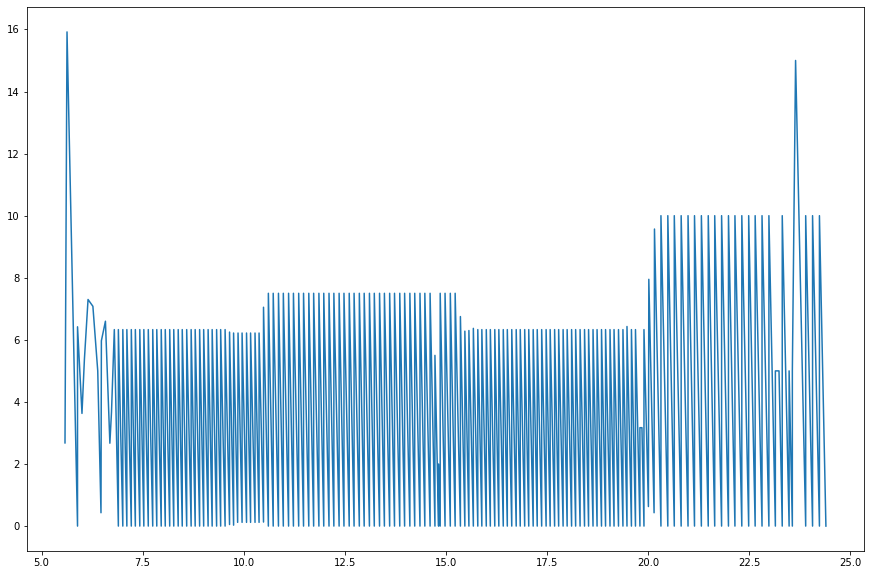

In [48]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15, 10))
plt.plot(x, y)
plt.plot(x, )
# naming the x axis
plt.xlabel('hours of the day')
# naming the y axis
plt.ylabel('Headway in min.')
plt.title('Headway for a whole day during the week at stop_id 8743 in direction 1 and with route_id 3')
plt.show()